In [1]:
import numpy as np
from scipy.stats import bernoulli
from scipy.stats import binom
from scipy.stats import geom
from tqdm import tqdm
import matplotlib.pyplot as plt
import sys

Just some utility to plot results and print out copy - pastable latex tables

In [2]:
def ploter(Ws,S_set): 
    #plots results
    fig,ax = plt.subplots(figsize=(7, 5))
    x = list(range(0, len(Ws[:,0])))
    for i in range(min(len(S_set),6)):
        ax.plot(x, Ws[x,i], label=f"state {S_set[i]}")
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Discounted Values')
    # ax.set_ylim([y_low, y_low+1])
    ax.legend(loc="upper left")
    
def latex_table(W_diff,S_set):
    # prints 
    res = np.concatenate(([0],W_diff.cumsum())) 
    res = [[v0-v1 for v1 in res] for v0 in res]
    for i,line in enumerate(res) :
        print(f"$\\sigma'={S_set[i]}$ &",end='')
        for v in line[:-1] :
            print(f'{v:.2f}',end=' & ')
        print(f'{line[-1]:.2f} \\\\')

## Monte Carlo Value iteration

Allows to parameterized a MC-Value iteration solver 

In [3]:
def monte_carlo_setter(P_sigma_r_given_sigma,S_set,R_set,c,d):
    # Takes a pMDP as input, 
    # Sets the iterator for MCVI
    support_size = len(S_set)*len(R_set)
    P = P_sigma_r_given_sigma.flatten()
    def s_sampler(n_draw):
#         samples n_draws from the distribution P_sigma_r_given_sigma
        X = np.random.choice(np.arange(support_size),n_draw,p=P)
        return (X//len(R_set), R_set[X%len(R_set)])   
    
    def U_of_sample(X,W,n_d):
#         given the sample X, ex-ante state values W, n_d = d(sigma), 
#         returns the expected utility when in state sigma
        c_table = np.array([c(i) for i in range(n_d)]*(X[0].size//n_d))
        return (gamma*W[X[0]] + X[1] - c_table).reshape(-1,n_d).max(1).mean()
    
    def value_iter_MC(gamma, n_sample, report, stop_cond, 
                  seed = 42, decrease_update_rate = True, W_start = 0, start_decrease = 1, reduce_W = 1):
#         Uses gamma as discount rate
#         will sample n_sample s per sigma,
#         report on accuracy every 'report' iteration, 
#         set random seed at seed, 
#         if decrease_update_rate, use accuracy as stop condition, else number of iteration
#         W_start serves to start closer to the game value, makes it easier than to set proper simulation parameters
#         start_decrease allows to start decreasing the update rate only after some iterations have passed
        np.random.seed(seed)
        Ws = np.ones((1,len(S_set)))*W_start
        i = 0
        while i<1 or continue_condition :
            i+=1
            if i%report==0:
                print(f'iteration {i:}, current accuracy is {accuracy}')
            W_next=np.zeros(len(S_set))
            for i_sigma, sigma in enumerate(S_set):
                n_d = d(sigma)
                n_draw = n_d * n_sample
                W_next[i_sigma] = U_of_sample(s_sampler(n_draw),Ws[-1,:],n_d)
            rate = 1/(i-start_decrease) if decrease_update_rate and i>start_decrease else 1
            Ws = np.concatenate((Ws,(Ws[-1,:]+(W_next-Ws[-1,:])*rate).reshape(1,-1)))
            accuracy = np.max(np.abs(Ws[-1,:]-Ws[-2,:]))
            continue_condition = accuracy > stop_cond if decrease_update_rate else i <= stop_cond
            if i%reduce_W == 0:
                Ws = np.concatenate((Ws[:-reduce_W],Ws[-1,:].reshape(1,-1)))
        print("\ndone")
        print(f"iteration {i:}, accuracy {accuracy}")
        for i_sigma,sigma in enumerate(S_set):
            print(f"state {sigma}, W(sigma) = {Ws[-1,i_sigma]}")
        return Ws
    return value_iter_MC

## Variable change

Allows to parameterized a variable change iteration solver 

In [4]:
def variable_change_setter(P_sigma_r_given_sigma,S_set,R_set,c,d,c_sup):
    # Takes a pMDP as input, 
    # Sets the iterator for VI with variable change
    def get_U_set_from_W(W,gamma):
        R_minus_c = np.unique(R_set.reshape(-1,1)- c_sup)
        return np.unique(np.sort((R_minus_c + gamma*W.reshape(-1,1)).flatten()))
    
    def compute_CDF_U_s(W,n_d,U_set,gamma,CDF_U_half=None):
        eps = np.diff(U_set).min()/10 
        if n_d == 1:
            P_U = np.zeros_like(U_set)
            inds = np.searchsorted(U_set+eps, R_set-c(0) + gamma*W.reshape(-1,1))
            np.add.at(P_U,inds,P_sigma_r_given_sigma)
            return P_U.cumsum()
        else:
            upsilon = c(n_d//2) - c(0)
#           inds = np.searchsorted(U_set-n_d//2+eps, np.minimum(U_set,U_set[-1]-n_d//2))
            inds = np.searchsorted(U_set+eps, np.minimum(U_set+upsilon,U_set[-1]))
            return CDF_U_half * CDF_U_half[inds]

    def compute_CDF_U (W,U_set,gamma):
        CDF_U = np.zeros((len(S_set),len(U_set)))
        for i,sigma in enumerate(S_set):
            n_d = d(sigma)
            CDF_U_half = CDF_U[i-1,:] if n_d>1 else None
            CDF_U[i,:] = compute_CDF_U_s (W,n_d,U_set,gamma,CDF_U_half)
        return CDF_U    

    def expected_from_CDF(X,CDF):
        return (CDF[:,0]*X[0]) + (np.diff(CDF,axis=1) * X[1:]).sum(1)

    P = P_sigma_r_given_sigma

    def value_iter_VC(gamma,report, stop_cond, seed = 42, accuracy_stop = True, W_start = 0, reduce_W = 1):
        # will report on accuracy every 'report' iteration, 
        # set random seed at seed, 
        # if accuracy_stop, use accuracy as stop condition, else number of iteration
        np.random.seed(seed)
        Ws = np.ones((1,len(S_set)))*W_start
        i =0
        while i<1 or continue_condition :
            i+=1
            if i%report==0:
                print(f'iteration {i:}, current accuracy is {accuracy}')
            U_set = get_U_set_from_W(Ws[-1,:],gamma)
            CDF_U = compute_CDF_U(Ws[-1,:],U_set,gamma)
            Ws = np.concatenate((Ws,expected_from_CDF(U_set,CDF_U).reshape(1,-1)))
            accuracy = np.max(np.abs(Ws[-1,:]-Ws[-2,:]))
            continue_condition = accuracy > stop_cond if accuracy_stop else i <= stop_cond
            if i%reduce_W == 0:
                Ws = np.concatenate((Ws[:-reduce_W],Ws[-1,:].reshape(1,-1)))
        print("\ndone")
        print(f"iteration {i:}, accuracy {accuracy}")
        n_s = min(6,len(S_set))
        for i_sigma,sigma in enumerate(S_set[:n_s]):
            print(f"state {sigma}, W(sigma) = {Ws[-1,i_sigma]}")
        return Ws
    return value_iter_VC

## Variable change - no discount

Allows to parameterized a variable change iteration solver - without a discount factor 

In [5]:
def variable_change_ND_setter(P_sigma_r_given_sigma,S_set,R_set,c,d,c_sup):
    # Takes a pMDP as input, 
    # Sets the iterator for VI with variable change with gamma=1
    
    def get_U_set_from_W(W,gamma):
        R_minus_c = np.unique(R_set.reshape(-1,1)- c_sup)
        return np.unique(np.sort((R_minus_c + gamma*W.reshape(-1,1)).flatten()))
    
    def compute_CDF_U_s(W,n_d,U_set,gamma,CDF_U_half=None):
        eps = np.diff(U_set).min()/10
        if n_d == 1:
            P_U = np.zeros_like(U_set)
            inds = np.searchsorted(U_set+eps, R_set-c(0) + gamma*W.reshape(-1,1))
            np.add.at(P_U,inds,P_sigma_r_given_sigma)
            return P_U.cumsum()
        else:
            upsilon = c(n_d//2) - c(0)
#           inds = np.searchsorted(U_set-n_d//2+eps, np.minimum(U_set,U_set[-1]-n_d//2))
            inds = np.searchsorted(U_set+eps, np.minimum(U_set+upsilon,U_set[-1]))
            return CDF_U_half * CDF_U_half[inds]

    def compute_CDF_U (W,U_set,gamma):
        CDF_U = np.zeros((len(S_set),len(U_set)))
        for i,sigma in enumerate(S_set):
            n_d = d(sigma)
            CDF_U_half = CDF_U[i-1,:] if n_d>1 else None
            CDF_U[i,:] = compute_CDF_U_s (W,n_d,U_set,gamma,CDF_U_half)
        return CDF_U    

    def expected_from_CDF(X,CDF):
        return (CDF[:,0]*X[0]) + (np.diff(CDF,axis=1) * X[1:]).sum(1)

    P = P_sigma_r_given_sigma

    def value_iter_VC_ND(report, stop_cond, seed = 42, accuracy_stop = True):
        # will report on accuracy every 'report' iteration, 
        # set random seed at seed, 
        # if accuracy_stop, use accuracy as stop condition, else number of iteration
        np.random.seed(seed)
        Ws_diff = np.zeros((1,len(S_set)-1))
        i = 0
        while i<1 or continue_condition :
            i+=1
            if i%report==0:
                print(f'iteration {i:}, current accuracy is {accuracy}')
            W = np.concatenate(([0], Ws_diff[-1,:])).cumsum()
            U_set = get_U_set_from_W(W,1)
            CDF_U = compute_CDF_U(W,U_set,1)
            W_diff = np.diff(expected_from_CDF(U_set,CDF_U))
            Ws_diff = np.concatenate((Ws_diff,W_diff.reshape(1,-1)))
            accuracy = np.max(np.abs(Ws_diff[-1,:]-Ws_diff[-2,:]))
            continue_condition = accuracy > stop_cond if accuracy_stop else i <= stop_cond
        print("\ndone")
        print(f"iteration {i:}, accuracy {accuracy}")
        n_s = min(6,len(S_set))
        for i_sigma,sigma in enumerate(S_set[1:n_s]):
            print(f"state {sigma}, Wdiff(sigma) = {Ws_diff[-1,i_sigma]}")
        W = np.concatenate(([0], Ws_diff[-1,:])).cumsum()
        U_set = get_U_set_from_W(W,1)
        CDF_U = compute_CDF_U(W,U_set,1)
        return Ws_diff, W, U_set, CDF_U,i
    return value_iter_VC_ND    

## Card Game

In [6]:
# Card game pMDP
S_set = np.array(['club','spade','diamond','heart'])
R_set = np.arange(10)+1

def init_P (S_set = S_set, R_set = R_set):
    P = np.ones((len(S_set),len(R_set)))/4/13
    P[:,-1] *=4
    return P
P_sigma_r_given_sigma = init_P()
def d_setter(s):
    match s:
        case 'club':
            return 1
        case 'spade':
            return 2
        case 'diamond':
            return 4
        case 'heart':
            return 8
        case _:
            print(f"d called without s, input was {s}")

d = d_setter
c = lambda i : 7+i
c_sup = np.arange(8)+7

### Variable change value iteration

In [7]:
# Parameters for the variable change value iteration
gamma = 0.99
accuracy = 1e-4
report = 1e2
W_start = 0
reduce_W = 1

iteration 100, current accuracy is 0.33953945426128485
iteration 200, current accuracy is 0.12428242139789347
iteration 300, current accuracy is 0.04549138568337696
iteration 400, current accuracy is 0.016651318409458327
iteration 500, current accuracy is 0.006094921062697267
iteration 600, current accuracy is 0.002230938226460921
iteration 700, current accuracy is 0.0008165955422754223
iteration 800, current accuracy is 0.0002989003782118971
iteration 900, current accuracy is 0.00010940720524388325

done
iteration 908, accuracy 9.994536900137518e-05
state club, W(sigma) = 89.41268457380367
state spade, W(sigma) = 90.8236362398513
state diamond, W(sigma) = 91.41585312618197
state heart, W(sigma) = 91.47639972180924


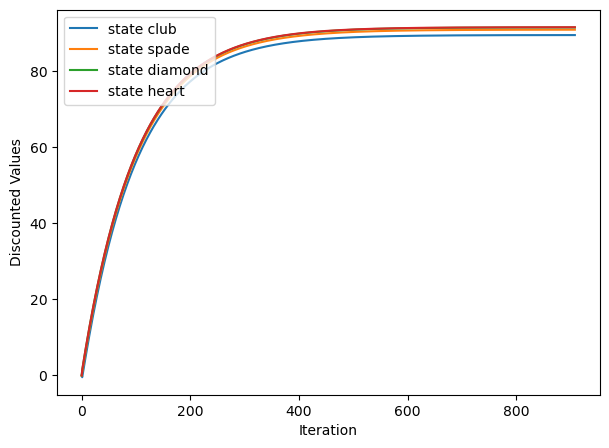

In [8]:
value_iter = variable_change_setter(P_sigma_r_given_sigma,S_set,R_set,c,d,c_sup)
Ws=value_iter(gamma,report,accuracy,W_start=W_start,reduce_W = reduce_W )
ploter(Ws,S_set)

### Monte Carlo Value Iteration

In [9]:
# Parameters for Monte Carlo value iteration
gamma = 0.99
accuracy = 1e-4
report = 1e2
W_start = 0
n_sample = int(1e3)
start_decrease = 1e3



iteration 100, current accuracy is 0.458039152566883
iteration 200, current accuracy is 0.17080070682946769
iteration 300, current accuracy is 0.28053957739598445
iteration 400, current accuracy is 0.1663922825105999
iteration 500, current accuracy is 0.1682493592209795
iteration 600, current accuracy is 0.20272610828084225
iteration 700, current accuracy is 0.24018677654727583
iteration 800, current accuracy is 0.10650014165483412
iteration 900, current accuracy is 0.2832544544243518
iteration 1000, current accuracy is 0.1899451183261931
iteration 1100, current accuracy is 0.0011950656738122234
iteration 1200, current accuracy is 0.0004979600568901787
iteration 1300, current accuracy is 0.00014261801565851329

done
iteration 1334, accuracy 7.291202234682714e-05
state club, W(sigma) = 90.14189984429352
state spade, W(sigma) = 91.54985103837934
state diamond, W(sigma) = 92.14400550413771
state heart, W(sigma) = 92.20991013749575


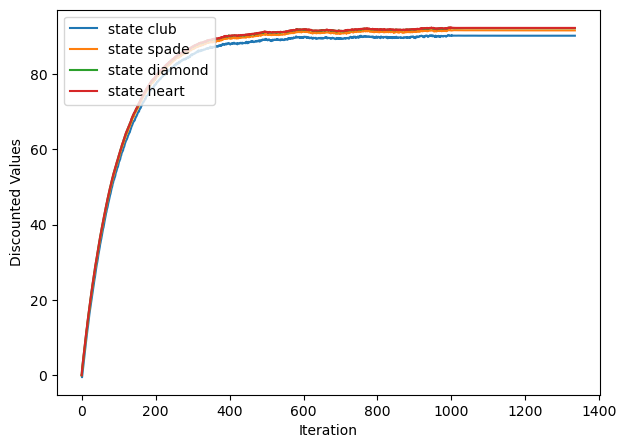

In [10]:
value_iter_MC = monte_carlo_setter(P_sigma_r_given_sigma,S_set,R_set,c,d)
Ws=value_iter_MC(gamma, n_sample,report,accuracy,W_start=W_start, start_decrease=start_decrease)
ploter(Ws,S_set)

### No Discount

In [11]:
# Parameters for the variable change value iteration
accuracy = 1e-4
report = 1e1


done
iteration 6, accuracy 1.5596833934594656e-05
state spade, Wdiff(sigma) = 1.41304271498828
state diamond, Wdiff(sigma) = 0.5960258483563527
state heart, Wdiff(sigma) = 0.061559091807067645


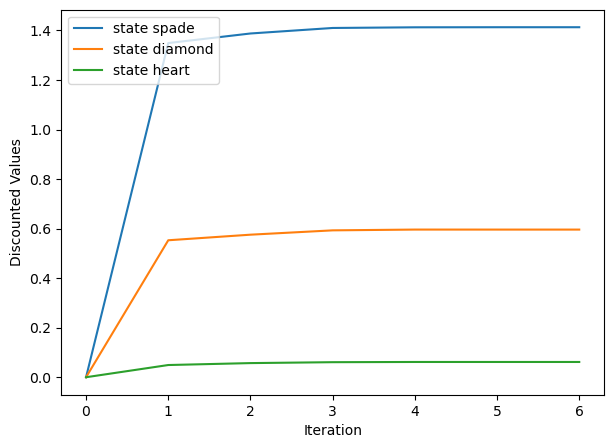

In [12]:
value_iter_VC_ND = variable_change_ND_setter(P_sigma_r_given_sigma,S_set,R_set,c,d,c_sup)
Ws_diff, W, U_set, CDF_U, i = value_iter_VC_ND(report, accuracy)
ploter(Ws_diff,S_set[1:])

In [13]:
latex_table(Ws_diff[-1,:],S_set)

$\sigma'=club$ &0.00 & -1.41 & -2.01 & -2.07 \\
$\sigma'=spade$ &1.41 & 0.00 & -0.60 & -0.66 \\
$\sigma'=diamond$ &2.01 & 0.60 & 0.00 & -0.06 \\
$\sigma'=heart$ &2.07 & 0.66 & 0.06 & 0.00 \\


## LRA on RANDAO

In [14]:
# LRA pMDP
n=32
stake = 0.3
S_set = np.arange(n+1)
#A = lambda a : np.arange(a)
R_set = np.arange(n+1)

def init_P (S_set = S_set, R_set = R_set,stake=stake):
    P = np.zeros((n+1,n+1))
    for s in range(n):
        for r in range(s,n):
            P[s,r] = geom.pmf(s+1,1-stake) * binom.pmf(r-s,n-s-1,stake)
    P[n,n] = geom.sf(n,1-stake)
    return P

P_sigma_r_given_sigma = init_P()
d = lambda s:int(2**s)
c = lambda i : bin(i).count("1")
c_sup = np.arange(n+1)

### Variable change value iteration

In [15]:
# Parameters for the variable change value iteration
gamma = 0.999
accuracy = 1e-5
report = 1e3
W_start = 10060
reduce_W = int(1e0)

iteration 1000, current accuracy is 0.001654215779126389
iteration 2000, current accuracy is 0.0006082475738367066
iteration 3000, current accuracy is 0.0002236498530692188
iteration 4000, current accuracy is 8.223503027693368e-05
iteration 5000, current accuracy is 3.0237446480896324e-05
iteration 6000, current accuracy is 1.1118172551505268e-05

done
iteration 6105, accuracy 9.999430403695442e-06
state 0, W(sigma) = 10063.933508625103
state 1, W(sigma) = 10065.090948650151
state 2, W(sigma) = 10066.057702005788
state 3, W(sigma) = 10066.881163036627
state 4, W(sigma) = 10067.598085863281
state 5, W(sigma) = 10068.235066058853


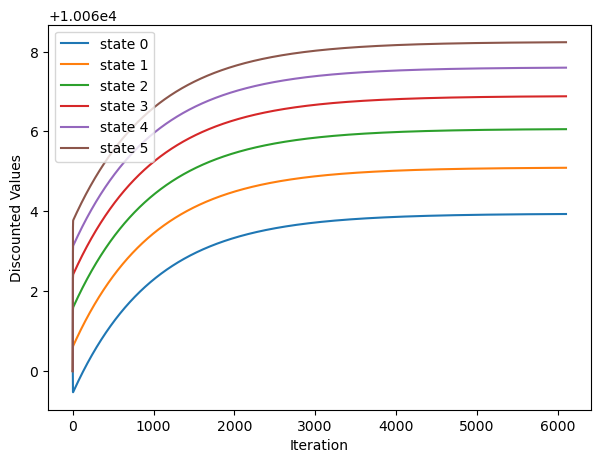

In [16]:
value_iter = variable_change_setter(P_sigma_r_given_sigma,S_set,R_set,c,d,c_sup)
Ws=value_iter(gamma,report,accuracy,W_start=W_start, reduce_W = reduce_W)
ploter(Ws,S_set)

### No Discount

In [17]:
# Parameters for the variable change value iteration
accuracy = 1e-5
report = 1e2


done
iteration 10, accuracy 2.223112471000377e-06
state 1, Wdiff(sigma) = 1.1577019382559808
state 2, Wdiff(sigma) = 0.9670503481393897
state 3, Wdiff(sigma) = 0.8237777153347459
state 4, Wdiff(sigma) = 0.7172503396315477
state 5, Wdiff(sigma) = 0.6373164566677758


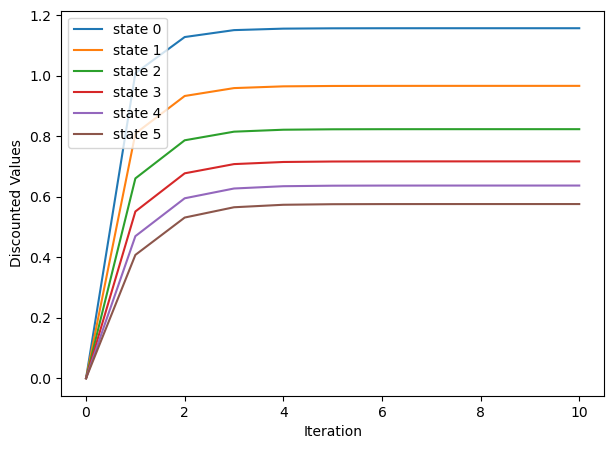

In [18]:
value_iter_ND = variable_change_ND_setter(P_sigma_r_given_sigma,S_set,R_set,c,d,c_sup)
Ws_diff, W, U_set, CDF_U, i =  value_iter_ND(report,accuracy)
ploter(Ws_diff,S_set)

In [19]:
latex_table(Ws_diff[-1,:4],S_set)

$\sigma'=0$ &0.00 & -1.16 & -2.12 & -2.95 & -3.67 \\
$\sigma'=1$ &1.16 & 0.00 & -0.97 & -1.79 & -2.51 \\
$\sigma'=2$ &2.12 & 0.97 & 0.00 & -0.82 & -1.54 \\
$\sigma'=3$ &2.95 & 1.79 & 0.82 & 0.00 & -0.72 \\
$\sigma'=4$ &3.67 & 2.51 & 1.54 & 0.72 & 0.00 \\


### Monte Carlo Value Iteration (Does not run because of complexity)

This part does not run as sampling $s$ is too hard for high ex-ante states...
For the last one : $\sigma=32$, we have $d(\sigma)=2^{32}$. Making the sampling of $s$ too complicated and preventing iterations   

In [20]:
# # Parameters for Monte Carlo value iteration
# gamma = 0.99
# accuracy = 1e-3
# report = 2
# W_start = 1020
# n_sample = int(1e0)
# start_decrease = 1e1



In [21]:
# # will not compute : when sigma = 32, cannot sample s of size 2**32
# value_iter_MC = monte_carlo_setter(P_sigma_r_given_sigma,S_set,R_set,c,d)
# Ws=value_iter_MC(gamma, n_sample,report,accuracy,W_start=W_start, start_decrease=start_decrease)
# ploter(Ws,S_set)

### Computation time estimation

In [22]:
import time

Computes the Average time per itearations for different stakes with the No-discount solver

In [23]:
n_s = [8,16,32,64,128,256,512,1024]
runs = [1000,1000,1000,1000,100,10,1,1]

stake = 0.3
accuracy = 1e-5
report = 1e10

def estimate_iteration_time(n_s,runs, stake):
    print(f"Run #\tKappa or n\tAvg tot time(ms)\tAvg i\tAvg time(ms)/i\tstd time/i(ms)")
        
    for n, run in zip(n_s,runs):
        S_set = np.arange(n+1)
        #A = lambda a : np.arange(a)
        R_set = np.arange(n+1)

        def init_P (S_set = S_set, R_set = R_set,stake=stake):
            P = np.zeros((n+1,n+1))
            for s in range(n):
                for r in range(s,n):
                    P[s,r] = geom.pmf(s+1,1-stake) * binom.pmf(r-s,n-s-1,stake)
            P[n,n] = geom.sf(n,1-stake)
            return P

        P_sigma_r_given_sigma = init_P()
        d = lambda s:int(2**s)
        c = lambda i : bin(i).count("1")
        c_sup = np.arange(n+1)
        
        def variable_change_ND_setter(P_sigma_r_given_sigma,S_set,R_set,c,d,c_sup):
            # Takes a pMDP as input, 
            # Sets the iterator for VI with variable change with gamma=1

            def get_U_set_from_W(W,gamma):
                R_minus_c = np.unique(R_set.reshape(-1,1)- c_sup)
                return np.unique(np.sort((R_minus_c + gamma*W.reshape(-1,1)).flatten()))

            def compute_CDF_U_s(W,sigma,U_set,gamma,CDF_U_half=None):
                eps = np.diff(U_set).min()/10
                if sigma == 0:
                    P_U = np.zeros_like(U_set)
                    inds = np.searchsorted(U_set+eps, R_set-c(0) + gamma*W.reshape(-1,1))
                    np.add.at(P_U,inds,P_sigma_r_given_sigma)
                    res = P_U.cumsum()
                    res /= res[-1]
                    return res
                else:
                    upsilon = 1
        #           inds = np.searchsorted(U_set-n_d//2+eps, np.minimum(U_set,U_set[-1]-n_d//2))
                    inds = np.searchsorted(U_set+eps, np.minimum(U_set+upsilon,U_set[-1]))
        #                 if sigma == 60 :
        #                     print(CDF_U_half[-1])
                    return CDF_U_half * CDF_U_half[inds]

        

            def compute_CDF_U (W,U_set,gamma):
                CDF_U = np.zeros((len(S_set),len(U_set)))
                for i,sigma in enumerate(S_set):
                    CDF_U_half = CDF_U[i-1,:] if sigma>0 else None
                    CDF_U[i,:] = compute_CDF_U_s (W,sigma,U_set,gamma,CDF_U_half)
                return CDF_U   


            def expected_from_CDF(X,CDF):
                return (CDF[:,0]*X[0]) + (np.diff(CDF,axis=1) * X[1:]).sum(1)

            P = P_sigma_r_given_sigma

            def value_iter_VC_ND(report, stop_cond, seed = 42, accuracy_stop = True):
                # will report on accuracy every 'report' iteration, 
                # set random seed at seed, 
                # if accuracy_stop, use accuracy as stop condition, else number of iteration
                np.random.seed(seed)
                Ws_diff = np.zeros((1,len(S_set)-1))
                i = 0
                while i<1 or continue_condition :
                    i+=1
                    if i%report==0:
                        print(f'iteration {i:}, current accuracy is {accuracy}')
                    W = np.concatenate(([0], Ws_diff[-1,:])).cumsum()
                    U_set = get_U_set_from_W(W,1)
                    CDF_U = compute_CDF_U(W,U_set,1)
                    W_diff = np.diff(expected_from_CDF(U_set,CDF_U))
                    Ws_diff = np.concatenate((Ws_diff,W_diff.reshape(1,-1)))
                    accuracy = np.max(np.abs(Ws_diff[-1,:]-Ws_diff[-2,:]))
                    continue_condition = accuracy > stop_cond if accuracy_stop else i <= stop_cond
                W = np.concatenate(([0], Ws_diff[-1,:])).cumsum()
                U_set = get_U_set_from_W(W,1)
                CDF_U = compute_CDF_U(W,U_set,1)
                return Ws_diff, W, U_set, CDF_U,i
            return value_iter_VC_ND     
        
        value_iter_ND = variable_change_ND_setter(P_sigma_r_given_sigma,S_set,R_set,c,d,c_sup)
        
        times = []
        is_ = []
        for _ in range(run):
            start = time.time()
            Ws_diff, W, U_set, CDF_U, i = value_iter_ND(report, accuracy)
            end = time.time()

            times.append(end - start)
            is_.append(i)

        times = np.array(times)
        is_ = np.array(is_)

        # Compute average time per i
        avg_time_per_i = times / is_
        print(f"{run}\t{n}\t\t{1000*times.mean():.4E}\t\t{is_.mean():.2f}\t{1000*avg_time_per_i.mean():.3E}\t{1000*avg_time_per_i.std():.3f}")
        
estimate_iteration_time(n_s,runs, stake)

Run #	Kappa or n	Avg tot time(ms)	Avg i	Avg time(ms)/i	std time/i(ms)
1000	8		1.0076E+00		9.00	1.120E-01	0.004
1000	16		2.4081E+00		9.00	2.676E-01	0.010
1000	32		1.1930E+01		10.00	1.193E+00	0.048
1000	64		9.2053E+01		10.00	9.205E+00	0.601
100	128		8.8662E+02		10.00	8.866E+01	1.139
10	256		8.3936E+03		10.00	8.394E+02	12.072
1	512		8.0062E+04		10.00	8.006E+03	0.000
1	1024		8.5930E+05		10.00	8.593E+04	0.000


### Average expected reward

This section quantifies the expected average rewards from different strategies

In [24]:
# stakes = [0.01]+list(np.arange(0.05,0.85,0.05))
stakes = np.arange(0.01,0.41,0.01)

#### For Optimal strategy

In [25]:
def compute_Ps_given_sigma(W,U_set, CDF_U):
    # support for the net reward gained in the transition 
    Rs = np.arange(-32,33)
    # with greedy, prob to go from sigma to sigma2 while earning net R
    P_sig_sig2_R = np.zeros((S_set.size,S_set.size,Rs.size))
    eps = np.diff(U_set).min()/10
    for sigma in S_set:
        for sigma2 in S_set:
            for r,R in enumerate(Rs):
                ind = np.searchsorted(U_set + eps, R + W[sigma2])
                P_sig_sig2_R[sigma,sigma2,r] = 0 if ind==0 else CDF_U[sigma,ind] - CDF_U[sigma,ind-1] 
    return P_sig_sig2_R, Rs

def compute_stationary(P,acc = 1e-7):
    x = np.zeros(P.shape[0])
    x2 = np.ones(P.shape[0])/P.shape[0]
    i = 0
    while np.abs(x-x2).max()>acc or i <100:
        i+=1
        x = x2
        x2 = x@P
    return x

In [26]:
# recompute W 
value_iter_ND = variable_change_ND_setter(P_sigma_r_given_sigma,S_set,R_set,c,d,c_sup)
Ws_diff, W, U_set, CDF_U, i = value_iter_ND(report, accuracy)


done
iteration 10, accuracy 2.223112471000377e-06
state 1, Wdiff(sigma) = 1.1577019382559808
state 2, Wdiff(sigma) = 0.9670503481393897
state 3, Wdiff(sigma) = 0.8237777153347459
state 4, Wdiff(sigma) = 0.7172503396315477
state 5, Wdiff(sigma) = 0.6373164566677758


In [27]:
P_sig_sig2_R, Rs = compute_Ps_given_sigma(W,U_set, CDF_U)
x = compute_stationary(P_sig_sig2_R.sum(2))
#This gives the expected average reward
(x * (P_sig_sig2_R.sum(1) * Rs.reshape(1,-1)).sum(1)).sum()

np.float64(10.064519557140073)

In [28]:
accuracy = 1e-5
report = 1e10
def average_reward_opti(n,stake):
    # LRA pMDP
    S_set = np.arange(n+1)
    #A = lambda a : np.arange(a)
    R_set = np.arange(n+1)

    def init_P (S_set = S_set, R_set = R_set,stake=stake):
        P = np.zeros((n+1,n+1))
        for s in range(n):
            for r in range(s,n):
                P[s,r] = geom.pmf(s+1,1-stake) * binom.pmf(r-s,n-s-1,stake)
        P[n,n] = geom.sf(n,1-stake)
        return P

    P_sigma_r_given_sigma = init_P()
    d = lambda s:int(2**s)
    c = lambda i : bin(i).count("1")
    c_sup = np.arange(n+1)
    
    
    def variable_change_ND_setter(P_sigma_r_given_sigma,S_set,R_set,c,d,c_sup):
        # Takes a pMDP as input, 
        # Sets the iterator for VI with variable change with gamma=1

        def get_U_set_from_W(W,gamma):
            R_minus_c = np.unique(R_set.reshape(-1,1)- c_sup)
            return np.unique(np.sort((R_minus_c + gamma*W.reshape(-1,1)).flatten()))

        def compute_CDF_U_s(W,sigma,U_set,gamma,CDF_U_half=None):
            eps = np.diff(U_set).min()/10
            if sigma == 0:
                P_U = np.zeros_like(U_set)
                inds = np.searchsorted(U_set+eps, R_set-c(0) + gamma*W.reshape(-1,1))
                np.add.at(P_U,inds,P_sigma_r_given_sigma)
                res = P_U.cumsum()
                res /= res[-1]
                return res
            else:
                upsilon = 1
    #           inds = np.searchsorted(U_set-n_d//2+eps, np.minimum(U_set,U_set[-1]-n_d//2))
                inds = np.searchsorted(U_set+eps, np.minimum(U_set+upsilon,U_set[-1]))
#                 if sigma == 60 :
#                     print(CDF_U_half[-1])
                return CDF_U_half * CDF_U_half[inds]
        
        
#         def compute_log_CDF_U_s(W,sigma,U_set,gamma,log_CDF_U_half=None):
#             eps = np.diff(U_set).min()/10
#             if sigma == 0:
#                 P_U = np.zeros_like(U_set)
#                 inds = np.searchsorted(U_set+eps, R_set-c(0) + gamma*W.reshape(-1,1))
#                 np.add.at(P_U,inds,P_sigma_r_given_sigma)
#                 res = P_U.cumsum()
#                 res /= res[-1]
#                 return P_U.cumsum()
#             else:
#                 upsilon = 1
#     #           inds = np.searchsorted(U_set-n_d//2+eps, np.minimum(U_set,U_set[-1]-n_d//2))
#                 inds = np.searchsorted(U_set+eps, np.minimum(U_set+upsilon,U_set[-1]))
#                 return CDF_U_half * CDF_U_half[inds]

        def compute_CDF_U (W,U_set,gamma):
            CDF_U = np.zeros((len(S_set),len(U_set)))
            for i,sigma in enumerate(S_set):
                CDF_U_half = CDF_U[i-1,:] if sigma>0 else None
                CDF_U[i,:] = compute_CDF_U_s (W,sigma,U_set,gamma,CDF_U_half)
            return CDF_U   
           

        def expected_from_CDF(X,CDF):
            return (CDF[:,0]*X[0]) + (np.diff(CDF,axis=1) * X[1:]).sum(1)

        P = P_sigma_r_given_sigma

        def value_iter_VC_ND(report, stop_cond, seed = 42, accuracy_stop = True):
            # will report on accuracy every 'report' iteration, 
            # set random seed at seed, 
            # if accuracy_stop, use accuracy as stop condition, else number of iteration
            np.random.seed(seed)
            Ws_diff = np.zeros((1,len(S_set)-1))
            i = 0
            while i<1 or continue_condition :
                i+=1
                if i%report==0:
                    print(f'iteration {i:}, current accuracy is {accuracy}')
                W = np.concatenate(([0], Ws_diff[-1,:])).cumsum()
                U_set = get_U_set_from_W(W,1)
                CDF_U = compute_CDF_U(W,U_set,1)
                W_diff = np.diff(expected_from_CDF(U_set,CDF_U))
                Ws_diff = np.concatenate((Ws_diff,W_diff.reshape(1,-1)))
                accuracy = np.max(np.abs(Ws_diff[-1,:]-Ws_diff[-2,:]))
                continue_condition = accuracy > stop_cond if accuracy_stop else i <= stop_cond
            W = np.concatenate(([0], Ws_diff[-1,:])).cumsum()
            U_set = get_U_set_from_W(W,1)
            CDF_U = compute_CDF_U(W,U_set,1)
            return Ws_diff, W, U_set, CDF_U
        return value_iter_VC_ND

    def compute_Ps_given_sigma(W,U_set, CDF_U):
        # support for the net reward gained in the transition 
        Rs = np.arange(-n,n+1)
        # with greedy, prob to go from sigma to sigma2 while earning net R
        P_sig_sig2_R = np.zeros((S_set.size,S_set.size,Rs.size))
        eps = np.diff(U_set).min()/10
        for sigma in S_set:
            for sigma2 in S_set:
                for r,R in enumerate(Rs):
                    ind = np.searchsorted(U_set + eps, R + W[sigma2])
                    P_sig_sig2_R[sigma,sigma2,r] = 0 if ind==0 else CDF_U[sigma,ind] - CDF_U[sigma,ind-1] 
        return P_sig_sig2_R, Rs

    def compute_stationary(P,acc = 1e-6):
        x = np.zeros(P.shape[0])
        x2 = np.ones(P.shape[0])/P.shape[0]
        i = 0
        while np.abs(x-x2).max()>acc:
            i+=1
            x = x2
            x2 = x@P
        return x
    
    
    value_iter_ND = variable_change_ND_setter(P_sigma_r_given_sigma,S_set,R_set,c,d,c_sup)
    Ws_diff,  W, U_set, CDF_U=value_iter_ND(report,accuracy)
    
    P_sig_sig2_R, Rs = compute_Ps_given_sigma(W,U_set, CDF_U)
    x = compute_stationary(P_sig_sig2_R.sum(2))
    
    return (x * (P_sig_sig2_R.sum(1) * Rs.reshape(1,-1)).sum(1)).sum()


In [29]:
n=32
print("stake\t\tExpected R\tReward (%)\tIncrease")
res = []
for stake in stakes:
    a = average_reward_opti(n,stake)
    res +=[a]
    print(f'{stake:.2f}:\t\t{a:.4f}\t\t{100*a/n:.3f}\t\t{a/stake/n:.3f}')

stake		Expected R	Reward (%)	Increase
0.01:		0.3203		1.001		1.001
0.02:		0.6420		2.006		1.003
0.03:		0.9652		3.016		1.005
0.04:		1.2897		4.030		1.008
0.05:		1.6155		5.048		1.010
0.06:		1.9424		6.070		1.012
0.07:		2.2704		7.095		1.014
0.08:		2.5994		8.123		1.015
0.09:		2.9293		9.154		1.017
0.10:		3.2602		10.188		1.019
0.11:		3.5920		11.225		1.020
0.12:		3.9247		12.265		1.022
0.13:		4.2582		13.307		1.024
0.14:		4.5926		14.352		1.025
0.15:		4.9279		15.400		1.027
0.16:		5.2640		16.450		1.028
0.17:		5.6009		17.503		1.030
0.18:		5.9387		18.559		1.031
0.19:		6.2774		19.617		1.032
0.20:		6.6169		20.678		1.034
0.21:		6.9572		21.741		1.035
0.22:		7.2985		22.808		1.037
0.23:		7.6406		23.877		1.038
0.24:		7.9837		24.949		1.040
0.25:		8.3279		26.025		1.041
0.26:		8.6731		27.103		1.042
0.27:		9.0193		28.185		1.044
0.28:		9.3666		29.271		1.045
0.29:		9.7150		30.359		1.047
0.30:		10.0645		31.452		1.048
0.31:		10.4152		32.548		1.050
0.32:		10.7672		33.648		1.051
0.33:		11.1206		34.752		1.053
0.34:		11.

In [30]:
# # to latex
# for s,r in zip(stakes,res):
#     print (f"({s},{r/n-s:.6f}) ",end="")

The next 2 cells can be used to compute solving times

In [31]:
# stake = 0.3
# # ns = [16,32,64,128,256,512]
# ns = [8,16,32,64,128]
# print("n\t\tExpected R\tReward (%)\tIncrease\t time(s)")
# res = []
# for n in ns:
#     start_time = time.time()
#     a = average_reward_opti(n,stake)
#     elapsed_time = time.time() - start_time
#     res +=[a]
#     print(f'{n:.2f}:\t\t{a:.4f}\t\t{100*a/n:.3f}\t\t{a/stake/n:.3f}\t{elapsed_time}')

In [32]:
# %%timeit
# n = 32
# stake = 0.3
# a = average_reward_opti(n,stake)

#### Computing the average reward for greedy strat

In [33]:
accuracy = 1e-5
report = 1e10
def average_reward_opti(n,stake):
    # LRA pMDP
    S_set = np.arange(n+1)
    #A = lambda a : np.arange(a)
    R_set = np.arange(n+1)

    def init_P (S_set = S_set, R_set = R_set,stake=stake):
        P = np.zeros((n+1,n+1))
        for s in range(n):
            for r in range(s,n):
                P[s,r] = geom.pmf(s+1,1-stake) * binom.pmf(r-s,n-s-1,stake)
        P[n,n] = geom.sf(n,1-stake)
        return P

    P_sigma_r_given_sigma = init_P()
    d = lambda s:int(2**s)
    c = lambda i : bin(i).count("1")
    c_sup = np.arange(n+1)
    

    def compute_Ps_given_sigma (U_set):
        # with greedy, prob to go from sigma to sigma2 while earning net R
        P_sig_sig2_R = np.zeros((S_set.size,S_set.size,U_set.size))
        # support for the net reward gained in the transition 
        Rs = U_set
        for sigma in S_set:
            if sigma ==0:
                P_sig_sig2_R[0,:,:] = P_sigma_r_given_sigma
            else:
                for sigma2 in S_set:
                    for R in Rs:
                        P_sig_sig2_R[sigma,sigma2,R] += \
                            P_sig_sig2_R[sigma-1,sigma2,R] * P_sig_sig2_R[sigma-1,:,:min(R+2,Rs[-1])].sum() + \
                            P_sig_sig2_R[sigma-1,:,:R].sum() * P_sig_sig2_R[sigma-1,sigma2,min(R+1,Rs[-1])]
        return P_sig_sig2_R, Rs

    def compute_stationary(P,acc = 1e-9):
        x = np.zeros(P.shape[0])
        x2 = np.ones(P.shape[0])/P.shape[0]
        i = 0
        while np.abs(x-x2).max()>acc:
            i+=1
            x = x2
            x2 = x@P
        return x
    
    
    U_set = np.arange(n+1)
    P_sig_sig2_R, Rs = compute_Ps_given_sigma(U_set)
    x = compute_stationary(P_sig_sig2_R.sum(2))
    
    return (x * (P_sig_sig2_R.sum(1) * Rs.reshape(1,-1)).sum(1)).sum()
print("stake\t\tExpected R\tReward (%)\tIncrease")
res = []
for stake in stakes:
    a = average_reward_opti(32,stake)
    res +=[a]
    print(f'{stake:.2f}:\t\t{a:.4f}\t\t{100*a/n:.3f}\t\t{a/stake/n:.3f}')

stake		Expected R	Reward (%)	Increase
0.01:		0.3203		1.001		1.001
0.02:		0.6420		2.006		1.003
0.03:		0.9651		3.016		1.005
0.04:		1.2896		4.030		1.007
0.05:		1.6153		5.048		1.010
0.06:		1.9421		6.069		1.012
0.07:		2.2699		7.094		1.013
0.08:		2.5987		8.121		1.015
0.09:		2.9285		9.151		1.017
0.10:		3.2591		10.185		1.018
0.11:		3.5906		11.221		1.020
0.12:		3.9229		12.259		1.022
0.13:		4.2560		13.300		1.023
0.14:		4.5899		14.343		1.025
0.15:		4.9246		15.389		1.026
0.16:		5.2600		16.438		1.027
0.17:		5.5962		17.488		1.029
0.18:		5.9332		18.541		1.030
0.19:		6.2709		19.596		1.031
0.20:		6.6093		20.654		1.033
0.21:		6.9484		21.714		1.034
0.22:		7.2882		22.776		1.035
0.23:		7.6288		23.840		1.037
0.24:		7.9700		24.906		1.038
0.25:		8.3120		25.975		1.039
0.26:		8.6547		27.046		1.040
0.27:		8.9981		28.119		1.041
0.28:		9.3422		29.194		1.043
0.29:		9.6869		30.272		1.044
0.30:		10.0325		31.351		1.045
0.31:		10.3787		32.433		1.046
0.32:		10.7256		33.518		1.047
0.33:		11.0733		34.604		1.049
0.34:		11.

In [34]:
# # to latex
# for s,r in zip(stakes,res):
#     print (f"({s},{r/n-s:.6f}) ",end="")

#### Computing the average reward for Max tail strat

In [35]:
accuracy = 1e-5
report = 1e10
def average_reward_opti(n,stake):
    # LRA pMDP
    S_set = np.arange(n+1)
    #A = lambda a : np.arange(a)
    R_set = np.arange(n+1)

    def init_P (S_set = S_set, R_set = R_set,stake=stake):
        P = np.zeros((n+1,n+1))
        for s in range(n):
            for r in range(s,n):
                P[s,r] = geom.pmf(s+1,1-stake) * binom.pmf(r-s,n-s-1,stake)
        P[n,n] = geom.sf(n,1-stake)
        return P

    P_sigma_r_given_sigma = init_P()
    d = lambda s:int(2**s)
    c = lambda i : bin(i).count("1")
    c_sup = np.arange(n+1)
    

    def compute_Ps_given_sigma (U_set):
        # with greedy, prob to go from sigma to sigma2 while earning net R
        P_sig_sig2_R = np.zeros((S_set.size,S_set.size,U_set.size*2-1))
        # support for the net reward gained in the transition 
        Rs = np.arange(-32,33)
        for sigma in S_set:
            if sigma ==0:
                P_sig_sig2_R[0,:,32:] = P_sigma_r_given_sigma
            else:
                for sigma2 in S_set:
                    for r,R in enumerate(Rs):
                        P_sig_sig2_R[sigma,sigma2,r] += \
                            P_sig_sig2_R[sigma-1,sigma2,r] * P_sig_sig2_R[sigma-1,:sigma2,:].sum() + \
                            P_sig_sig2_R[sigma-1,sigma2,r] * P_sig_sig2_R[sigma-1,sigma2,:].sum() 
                        if R<32:
                            P_sig_sig2_R[sigma,sigma2,r] += \
                            P_sig_sig2_R[sigma-1,:sigma2,:].sum() * P_sig_sig2_R[sigma-1,sigma2,r+1]
        return P_sig_sig2_R, Rs

    def compute_stationary(P,acc = 1e-9):
        x = np.zeros(P.shape[0])
        x2 = np.ones(P.shape[0])/P.shape[0]
        i = 0
        while np.abs(x-x2).max()>acc:
            i+=1
            x = x2
            x2 = x@P
        return x
    
    
    U_set = np.arange(n+1)
    P_sig_sig2_R, Rs = compute_Ps_given_sigma(U_set)
    x = compute_stationary(P_sig_sig2_R.sum(2))
    
    return (x * (P_sig_sig2_R.sum(1) * Rs.reshape(1,-1)).sum(1)).sum()
print("stake\t\tExpected R\tReward (%)\tIncrease")
res = []
for stake in stakes:
    a = average_reward_opti(32,stake)
    res +=[a]
    print(f'{stake:.2f}:\t\t{a:.4f}\t\t{100*a/n:.3f}\t\t{a/stake/n:.3f}')

stake		Expected R	Reward (%)	Increase
0.01:		0.3200		1.000		1.000
0.02:		0.6400		2.000		1.000
0.03:		0.9600		3.000		1.000
0.04:		1.2799		4.000		1.000
0.05:		1.5999		5.000		1.000
0.06:		1.9198		5.999		1.000
0.07:		2.2396		6.999		1.000
0.08:		2.5594		7.998		1.000
0.09:		2.8792		8.997		1.000
0.10:		3.1989		9.997		1.000
0.11:		3.5185		10.995		1.000
0.12:		3.8381		11.994		1.000
0.13:		4.1576		12.992		0.999
0.14:		4.4770		13.991		0.999
0.15:		4.7963		14.988		0.999
0.16:		5.1155		15.986		0.999
0.17:		5.4346		16.983		0.999
0.18:		5.7536		17.980		0.999
0.19:		6.0725		18.977		0.999
0.20:		6.3913		19.973		0.999
0.21:		6.7099		20.969		0.999
0.22:		7.0284		21.964		0.998
0.23:		7.3468		22.959		0.998
0.24:		7.6650		23.953		0.998
0.25:		7.9831		24.947		0.998
0.26:		8.3010		25.940		0.998
0.27:		8.6186		26.933		0.998
0.28:		8.9361		27.925		0.997
0.29:		9.2534		28.917		0.997
0.30:		9.5704		29.908		0.997
0.31:		9.8872		30.898		0.997
0.32:		10.2037		31.887		0.996
0.33:		10.5199		32.875		0.996
0.34:		10.835

In [36]:
# # to latex
# for s,r in zip(stakes,res):
#     print (f"({s},{r/n-s:.6f}) ",end="")

In [37]:
# # to latex
# for s,r in zip(stakes,res):
#     print (f"({s:.2f},{0:.2f}) ",end="")